# Open the box


## Objetices

Access the full data set and estimate the number of signal events

 * Consider the case of a counting experiment, estimate the number of signal events in the RoI, $n^{\beta\beta}_{RoI}$. 

 * Estimate the $n^{\beta\beta}_E$ events in the enlarged energy window.

 In both cases set a limit or a confidence interval for $\mathcal{T}_{1/2}^{\beta\beta0\nu}$

## Analysis

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#### Importing modules

In [2]:
import numpy  as np
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt

import scipy.constants as constants
import scipy.stats     as stats
import scipy.optimize  as optimize

import warnings
warnings.filterwarnings('ignore')

In [3]:
# REMEMBER TO ADD Your Fanal FOLDER TO PYTHONPATH
import os
import sys
rootpath = os.getcwd()[:-15]
print('add path to PYTHONPATH : ', rootpath)
sys.path.insert(0, os.path.abspath(rootpath))

add path to PYTHONPATH :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal-v2


In [11]:
import core.pltext  as pltext   # extensions for plotting histograms
import core.hfit    as hfit     # extension to fit histograms
import core.efit    as efit     # Fit Utilites - Includes Extend Likelihood Fit with composite PDFs
import core.utils   as ut       # generic utilities
import core.confint as confint  # Confidence Intervals 
import ana.fanal    as fn       # analysis functions specific to fanal
import notebooks.guide.collpars as collpars # collaboration specific parameters
pltext.style()

### Main Parameters

In [12]:
coll          = collpars.collaboration
sel_ntracks   = collpars.sel_ntracks
sel_eblob2    = collpars.sel_eblob2
sel_erange    = collpars.sel_erange
sel_eroi      = collpars.sel_eroi

print('Collaboration             : {:s}'.format(coll))
print('number of tracks range    : {:6d}'.format(sel_ntracks))
print('Blob-2 energy range       : {:6.3f}  MeV'.format(sel_eblob2))
print('Energy range              : ({:6.3f}, {:6.3f}) MeV'.format(*sel_erange))
print('Energy RoI range          : ({:6.3f}, {:6.3f}) MeV'.format(*sel_eroi))

Collaboration             : new_beta
number of tracks range    :      1
Blob-2 energy range       :  0.400  MeV
Energy range              : ( 2.400,  2.700) MeV
Energy RoI range          : ( 2.430,  2.480) MeV


In [13]:
n_Bi_RoI  = collpars.n_Bi_RoI
n_Tl_RoI  = collpars.n_Tl_RoI

n_Bi_E    = collpars.n_Bi_E
n_Tl_E    = collpars.n_Tl_E

print('Number Bi events in RoI = {:6.3f}'.format(n_Bi_RoI))
print('Number Tl events in RoI = {:6.3f}'.format(n_Tl_RoI))
print('Number Bi events in E   = {:6.3f}'.format(n_Bi_E))
print('Number Tl events in E   = {:6.3f}'.format(n_Tl_E))

Number Bi events in RoI = 21.765
Number Tl events in RoI =  4.008
Number Bi events in E   = 25.276
Number Tl events in E   = 150.816


## Access the data

In [14]:
# set the path to the data directory and filenames
dirpath = rootpath+'/data/'
filename = 'fanal_' + coll + '.h5'
print('Data path and filename : ', dirpath + filename)

mcbi = pd.read_hdf(dirpath + filename, key = 'mc/bi214')
mctl = pd.read_hdf(dirpath + filename, key = 'mc/tl208')

datab = pd.read_hdf(dirpath + filename, key = 'data/blind')
datar = pd.read_hdf(dirpath + filename, key = 'data/roi')
data  = pd.concat((datab, datar)) # concatenate blind and roi-data into one data DF

Data path and filename :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal-v2/data/fanal_new_beta.h5


### Plot the energy distribution

Number of expected backgrounds events in RoI = 25.773
Number of expected backgrounds events in RoI = 36


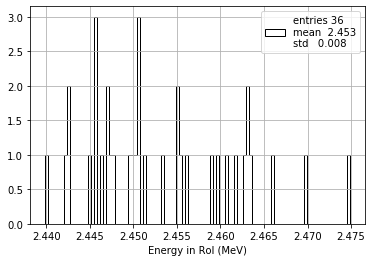

In [19]:
mask1 = (data.E >= sel_erange[0]) & (data.E < sel_erange[1])

mask2 = mask1 & (data.num_tracks <= sel_ntracks)
mask3 = mask2 & (data.blob2_E >= sel_eblob2)
mask4 = mask3 & (data.E >= sel_eroi[0]) & (data.E < sel_eroi[1])

pltext.hist(data.E[mask4], 100);
plt.xlabel("Energy in RoI (MeV)");

nobs = sum(mask4)
nbkg = n_Bi_RoI + n_Tl_RoI

print("Number of expected backgrounds events in RoI = {:6.3f}".format(nbkg))
print("Number of expected backgrounds events in RoI = {:d}".format(nobs))

In [20]:
nbkg   = n_Bi_RoI + n_Tl_RoI
n0     = nobs      # number of observed events (int)
cls    = (0.68, 0.90, 0.95)    # range of CL to show
factor = 1.5
nbins  = 100
nus    = np.linspace(0., factor * nbkg, 100) # range of number of signal events

# get the FC-CI functions for 68% and 95% CL
fcs    = [confint.get_fc_confinterval(nus, nbkg, cl = cl) for cl in cls]

for fc, cl in zip(fcs, cls):
    ci = fc(n0)
    print('FC Cover Interval, observed n = {:d}, at {:2.0f} % CL = ({:4.2f}, {:4.2f})'.format(n0, 100*cl, *ci))

FC Cover Interval, observed n = 36, at 68 % CL = (4.69, 16.79)
FC Cover Interval, observed n = 36, at 90 % CL = (2.73, 21.09)
FC Cover Interval, observed n = 36, at 95 % CL = (1.17, 23.43)


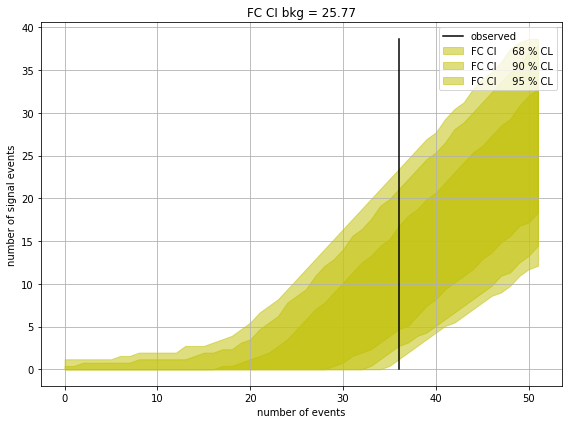

In [21]:
# plot the conficence band and the segment associated to an observation
pltext.canvas(1, 1, 6, 8)
ns   = np.arange(0, 2 * nbkg)
for fc, cl in zip(fcs, cls):    
    ys   = fc(ns)
    plt.fill_between(ns, *ys, alpha = 0.5, color = 'y', label = 'FC CI {:6.0f} % CL'.format(100*cl))
plt.plot(n0 * np.ones(len(nus)), nus, label = 'observed')
plt.legend(); plt.grid(which = 'both');
plt.title('FC CI bkg = {:4.2f}'.format(nbkg));
plt.xlabel('number of events'); plt.ylabel('number of signal events');
plt.tight_layout();

In [22]:
def tau(nbb):
    acc_bb   = collpars.acc_bb
    eff      = collpars.eff_bb_RoI
    exposure = collpars.exposure
    tau      = fn.half_life(nbb, exposure, acc_bb * eff)
    return tau

In [23]:
for fc, cl in zip(fcs, cls):
    ci   = fc(n0)
    taus = [tau(x) for x in ci]
    taus.reverse()
    print('FC Cover Interval, observed n = {:d}, at {:2.0f} % CL = ({:4.2e}, {:4.2e})'.format(n0, 100*cl, *taus))

FC Cover Interval, observed n = 36, at 68 % CL = (6.75e+25, 2.42e+26)
FC Cover Interval, observed n = 36, at 90 % CL = (5.38e+25, 4.15e+26)
FC Cover Interval, observed n = 36, at 95 % CL = (4.84e+25, 9.68e+26)


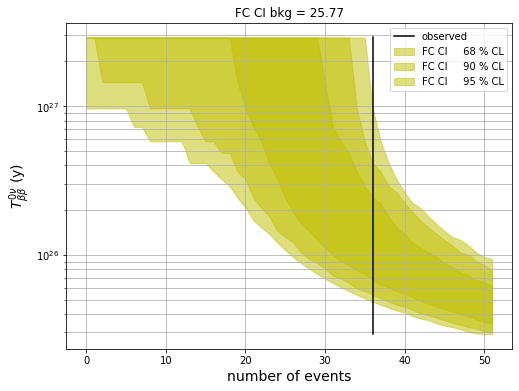

In [24]:
pltext.canvas(1, 1, 6, 8)
for fc, cl in zip(fcs, cls):    
    ys     = fc(ns)
    taus   = tau(ys)
    taus[taus == np.inf] = tau(nus[1])
    plt.fill_between(ns, *taus, 
                     alpha = 0.5, color = 'y', label = 'FC CI {:6.0f} % CL'.format(100*cl))
plt.plot(n0 * np.ones(len(nus)), tau(nus), label = 'observed')
plt.legend(); plt.grid(which = 'both');
plt.title('FC CI bkg = {:4.2f}'.format(nbkg));
plt.xlabel('number of events', fontsize = 14); plt.ylabel(r'$T^{0\nu}_{\beta\beta}$ (y)', fontsize = 14);
plt.yscale('log');
#plt.tight_layout();

In [25]:
p0 = stats.poisson.sf(nobs, nbkg) 

print('p0-values = {:1.2e} for n = {:d}, Tbb = {:1.2e} y'.format(p0, nobs, tau(nobs-nbkg)))

p0-values = 2.18e-02 for n = 36, Tbb = 1.11e+26 y
